In [1]:
import pysam
import pandas as pd
import pyBigWig
import hdbscan
import networkx as nx
import numpy as np
import bioframe as bf
import statsmodels.api as sm
from scipy.stats import t
import matplotlib.pyplot as plt
import multiprocessing
from functools import partial
import scipy.stats as stats
import os
from sklearn.neighbors import NearestNeighbors
import matplotlib.colors as mcolors


In [2]:
def import_reads(bam_file,chrom):
    bamfile = pysam.AlignmentFile(bam_file, "rb")
    bam_iter = bamfile.fetch(chrom)

    bam_dfs = []
    for ix in bam_iter:
        bam_dfs.append(pd.DataFrame({'ID':[ix.to_dict()['name']],'chrom':[ix.to_dict()['ref_name']],'start':[ix.to_dict()['ref_pos']],'flag':[ix.to_dict()['flag']]}))

    bam_df = pd.concat(bam_dfs).assign(start = lambda df_: df_.start.astype(int))

    return bam_df

In [3]:
def perform_HDBScan_clustering(read_tbl,min_cluster,processes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster,
                        metric='euclidean',
                        core_dist_n_jobs=processes)
    clusterer.fit(read_tbl.loc[:,['start']])

def collect_hdb_cluster_read(g):
    
    leaves = set([v for v, d in g.out_degree() if d == 0])
    HDB_clusters = [v for v, d in g.out_degree() if d > 0]

    cl_read_idx = [list(nx.descendants(g,i).intersection(leaves)) for i in HDB_clusters]
    cl_read_tbl = pd.DataFrame({"HDB_cluster":HDB_clusters,"read_id_set":cl_read_idx})
    return(cl_read_tbl)

def build_hic_zscore(data_tbl,vars,vars_df,vars_degree,target_var):
    """
        Computes statistical values (z-scores and p-values) for a given dataset using a smoothing model.

        This function applies a Generalized Additive Model (GAM) with B-splines to analyze the relationship
        between selected variables and a target variable. It returns the original dataset with two additional
        columns: 
        - `zscore`: A measure of how much each data point deviates from the average.
        - `pvalue`: A value indicating the significance of each data point.

        Parameters:
        -----------
        data_tbl : pandas.DataFrame
            The dataset containing the variables to be analyzed.
        
        vars : list of str
            The names of the columns to be used as predictors (independent variables).
        
        vars_df : int
            The number of degrees of freedom for the spline smoothing.
        
        vars_degree : int
            The degree of the spline function, which controls how smooth the curve is.
        
        target_var : str
            The column name of the target variable (dependent variable) being analyzed.

        Returns:
        --------
        pandas.DataFrame
            The original dataset with two additional columns:
            - `zscore`: The standardized residuals (how different each value is from the model's prediction).
            - `pvalue`: A probability score indicating the significance of each data point.
        
        Example:
        --------
        Suppose `data_tbl` contains genetic data, where `vars` represents different genetic markers, 
        and `target_var` is a measure of gene expression. This function helps determine which data 
        points significantly deviate from the expected pattern.
    """
    x_spline = data_tbl[vars].to_numpy(dtype=float)
    y = data_tbl[target_var].to_numpy(dtype=float)
    bs = sm.gam.BSplines(x_spline, df=vars_df, degree=vars_degree)

    chr_gam = sm.GLMGam(y,smoother=bs)
    chr_gam_res = chr_gam.fit()
    gam_infl = chr_gam_res.get_influence()
    bs_tranform_exog = bs.transform(data_tbl[vars].to_numpy())
    tmp_rng = chr_gam_res.get_distribution(exog=bs_tranform_exog)
    mod_pvalue = tmp_rng.sf(data_tbl[target_var].to_numpy())
    new_data_tbl = data_tbl.assign(zscore = gam_infl.resid_studentized,pvalue = mod_pvalue)
    return new_data_tbl


In [4]:
class read_clustering:
    def __init__(self,read_df):
        self.read_tbl = read_df
        self.chrom = read_df.iloc[0,:].chrom
        self.full_graph = None
        self.cl_read_tbl = None
        self.regression_tbl = None
        self.res_tbl = None
        self.summary_tbl = None
    
    def HDBScan_clustering(self,min_size,njobs):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size,
                        metric='euclidean',
                        core_dist_n_jobs=njobs)
        clusterer.fit(self.read_tbl.loc[:,['start']])
        self.full_graph = clusterer.condensed_tree_.to_networkx()
    
    def collect_hdb_cluster_read(self):
    
        leaves = set([v for v, d in self.full_graph.out_degree() if d == 0])
        HDB_clusters = [v for v, d in self.full_graph.out_degree() if d > 0]

        cl_read_idx = [list(nx.descendants(self.full_graph,i).intersection(leaves)) for i in HDB_clusters]
        tmp_cl_read_tbl = pd.DataFrame({"HDB_cluster":HDB_clusters,"read_id_set":cl_read_idx})
        node_depth = nx.shortest_path_length(self.full_graph,source=tmp_cl_read_tbl.HDB_cluster.min())
        tmp_cl_read_tbl = (tmp_cl_read_tbl
                           .assign(lvl = lambda df_: [node_depth[i] for i in df_.HDB_cluster.to_list()])
                           .assign(norm_lvl = lambda df_: df_.lvl/df_.lvl.max()))

        long_cl_read_tbl = tmp_cl_read_tbl.explode('read_id_set')

        long_cl_read_tbl = (long_cl_read_tbl
                            .assign(start = lambda df_:self.read_tbl.reset_index().start.to_numpy()[df_.read_id_set.to_numpy(dtype=int)])
                            )

        self.cl_read_tbl = (long_cl_read_tbl
                                        .groupby('HDB_cluster')
                                        .agg(start = ('start','min'),
                                            end=('start','max'),
                                            rc = ('start','count')
                                            )
                                        .assign(w= lambda df_:df_.end - df_.start)
                                    ).reset_index().merge(tmp_cl_read_tbl)

    def  build_regression_tbl(self,ctrl_read_df):

        bg_coord_df = ctrl_read_df.loc[:,['chrom','start']].assign(start = lambda df_: df_.start.astype(int)).assign(end = lambda df_: df_.start + 1)
        hdb_cluster_bg_rc_df = bf.count_overlaps(self.cl_read_tbl.assign(chrom = self.chrom).loc[:,['chrom','start','end','HDB_cluster']],bg_coord_df)
        tmp_chr_hdb_summary_tbl = self.cl_read_tbl.merge(hdb_cluster_bg_rc_df.rename(columns={'count':'bg_count'}))
        
        self.regression_tbl = (tmp_chr_hdb_summary_tbl
                    .loc[:,['HDB_cluster','rc','bg_count']]
                    .assign(lrc = lambda df_: np.log10(df_.rc), lbg = lambda df_: np.log10(df_.bg_count))
                    .assign(lbg2 = lambda df_: np.where(df_.bg_count.lt(1),0,df_.lbg))
                    )
    def compute_zscore(self,explanatory_vars,vars_df,vard_degree,target_variable):
        mod_res_tbl = build_hic_zscore(self.regression_tbl,explanatory_vars,vars_df,vard_degree,target_variable)
        self.res_tbl = self.regression_tbl.merge(mod_res_tbl)
        self.summary_tbl =   (self.res_tbl
                                .merge(self.cl_read_tbl.assign(chrom = self.chrom).loc[:,['HDB_cluster','chrom','start','end','w','norm_lvl']])
                                .assign(FC = lambda df_: (df_.rc/df_.w)/((df_.bg_count+1)/df_.w))
                             )



    

In [5]:
def match_cluster(rep1_cl_read_tbl,rep2_cl_read_tbl):

    rep_overlap_df = (bf.overlap(rep1_cl_read_tbl.loc[:,['chrom','start','end','HDB_cluster']],
                                 rep2_cl_read_tbl.loc[:,['chrom','start','end','HDB_cluster']],
                                 return_overlap=True,
                                 how='inner',suffixes=['_rep1','_rep2'])
    .assign(inter_w=lambda df_:(df_.overlap_end-df_.overlap_start),
            end_point=lambda df_:df_[["end_rep1","end_rep2"]].values.tolist(),
            start_points = lambda df_:df_[["start_rep1","start_rep2"]].values.tolist())
    .assign(jaccard = lambda df_:df_.inter_w/(df_.end_point.apply(max) - df_.start_points.apply(min)))
    .drop(['end_point','start_points'],axis=1)
    )

    rep1_max_jaccard_idx = (rep_overlap_df
            .groupby(['chrom_rep1','start_rep1','end_rep1','HDB_cluster_rep1'])
            .jaccard.idxmax()
            )

    rep2_max_jaccard_idx = (rep_overlap_df
            .groupby(['chrom_rep2','start_rep2','end_rep2','HDB_cluster_rep2'])
            .jaccard.idxmax()
            )

    rep1_matching_tbl = rep_overlap_df.iloc[rep1_max_jaccard_idx,:]
    rep2_matching_tbl = rep_overlap_df.iloc[rep2_max_jaccard_idx,:]

    return (
        rep1_matching_tbl,
        rep2_matching_tbl
        )

def get_CvM_pvalue(i,tbl):
    return stats.cramervonmises_2samp(tbl.iloc[i].rep1_start,tbl.iloc[i].rep2_start).pvalue

def get_matched_cluster_agreement_pvalue(rep_match_tbl,rep1_clustering,rep2_clustering,njobs):
    tmp_rep1_read_start_tbl = (rep_match_tbl.loc[:,['HDB_cluster_rep1']]
    .drop_duplicates()
    .merge(rep1_clustering.cl_read_tbl.loc[:,['HDB_cluster','read_id_set']],left_on = ['HDB_cluster_rep1'],right_on = ['HDB_cluster'])
    .drop('HDB_cluster',axis=1)
    .assign(DNA_start = lambda df_: df_.apply(lambda x:rep1_clustering.read_tbl.start.iloc[x.read_id_set].to_numpy(),axis=1))
    .drop('read_id_set',axis=1)
    .rename(columns={'DNA_start':"rep1_start"})
    )

    tmp_rep2_read_start_tbl = (rep_match_tbl.loc[:,['HDB_cluster_rep2']]
    .drop_duplicates()
    .merge(rep2_clustering.cl_read_tbl.loc[:,['HDB_cluster','read_id_set']],left_on = ['HDB_cluster_rep2'],right_on = ['HDB_cluster'])
    .drop('HDB_cluster',axis=1)
    .assign(DNA_start = lambda df_: df_.apply(lambda x:rep2_clustering.read_tbl.start.iloc[x.read_id_set].to_numpy(),axis=1))
    .drop('read_id_set',axis=1)
    .rename(columns={'DNA_start':"rep2_start"})
    )

    rep_match_read_coord_tbl = (rep_match_tbl
    .loc[:,['HDB_cluster_rep1','HDB_cluster_rep2','jaccard']]
    .merge(tmp_rep1_read_start_tbl)
    .merge(tmp_rep2_read_start_tbl)
    )

    with multiprocessing.Pool(processes=njobs) as pool:
            # Using map_async method to perform square operation on all numbers parallely
            read_agreement_pvalue = pool.map(partial(get_CvM_pvalue, tbl = rep_match_read_coord_tbl),
                                            range(rep_match_read_coord_tbl.shape[0])) 
    return rep_match_read_coord_tbl.assign(cvm_pvalue = read_agreement_pvalue).loc[:,['HDB_cluster_rep1','HDB_cluster_rep2','jaccard','cvm_pvalue']]   

       
class merged_clustering:
    def __init__(self,rep1_clustering,rep2_clustering):
        self.rep1 = rep1_clustering
        self.rep2 = rep2_clustering
        self.chrom = self.rep1.read_tbl.iloc[0,:].chrom
        self.rep1_match_tbl = None
        self.rep2_match_tbl = None
        self.robust_cluster_coord_tbl = None
        self.inter_rep_match_tbl = None
        
    def match_rep_cluster(self):
        self.rep1_match_tbl, self.rep2_match_tbl = match_cluster(self.rep1.summary_tbl,self.rep2.summary_tbl)        

    def evaluate_overlap_significance(self,njobs):
            self.rep1_match_pvalue_tbl = get_matched_cluster_agreement_pvalue(self.rep1_match_tbl,self.rep1,self.rep2,njobs)
            self.rep2_match_pvalue_tbl = get_matched_cluster_agreement_pvalue(self.rep2_match_tbl,self.rep1,self.rep2,njobs)


    def filter_significant_overlap_cluster(self,CvM_thresh,specificity_thresh):
        
        rep1_matched_cluster_ID_list = self.rep1_match_pvalue_tbl.query("cvm_pvalue > @CvM_thresh").HDB_cluster_rep1.drop_duplicates().to_list()
        rep2_matched_cluster_ID_list = self.rep2_match_pvalue_tbl.query("cvm_pvalue > @CvM_thresh").HDB_cluster_rep2.drop_duplicates().to_list()

        rep1_robust_cluster_tbl = (self.rep1
                                    .summary_tbl.loc[:,['HDB_cluster','chrom','start','end','zscore','pvalue']]
                                    .query("HDB_cluster in @rep1_matched_cluster_ID_list")
                                    .assign(rep = "rep1")
                                    .merge(self.rep1_match_pvalue_tbl,left_on='HDB_cluster',right_on="HDB_cluster_rep1")
                                    .drop('HDB_cluster',axis=1)
                                    .query("HDB_cluster_rep2 in @rep2_matched_cluster_ID_list")
                                    .merge(self.rep2.summary_tbl.loc[:,['HDB_cluster','pvalue']].rename(columns={'HDB_cluster':'HDB_cluster_rep2','pvalue':'pvalue_rep2'}))
                                    .query('pvalue < @specificity_thresh and pvalue_rep2 < @specificity_thresh')
                                    .loc[:,['chrom','start','end','zscore','pvalue','rep','HDB_cluster_rep1','HDB_cluster_rep2','jaccard','cvm_pvalue']]
                                )
        rep2_robust_cluster_tbl = (self.rep2
                                    .summary_tbl.loc[:,['HDB_cluster','chrom','start','end','zscore','pvalue']]
                                    .query("HDB_cluster in @rep2_matched_cluster_ID_list")
                                    .assign(rep = "rep2")
                                    .merge(self.rep2_match_pvalue_tbl,left_on='HDB_cluster',right_on="HDB_cluster_rep2")
                                    .drop('HDB_cluster',axis=1)
                                    .query("HDB_cluster_rep1 in @rep1_matched_cluster_ID_list")
                                    .merge(self.rep1.summary_tbl.loc[:,['HDB_cluster','pvalue']].rename(columns={'HDB_cluster':'HDB_cluster_rep1','pvalue':'pvalue_rep1'}))
                                    .query('pvalue < @specificity_thresh and pvalue_rep1 < @specificity_thresh')
                                    .loc[:,['chrom','start','end','zscore','pvalue','rep','HDB_cluster_rep2','HDB_cluster_rep1','jaccard','cvm_pvalue']]
                                )
        if (rep1_robust_cluster_tbl.shape[0] > 0 and rep2_robust_cluster_tbl.shape[0]):
            self.robust_cluster_match_tbl = bf.cluster(pd.concat([rep1_robust_cluster_tbl.drop('HDB_cluster_rep2',axis=1).rename(columns={'HDB_cluster_rep1':'HDB_cluster'}),
                                                                  rep2_robust_cluster_tbl.drop('HDB_cluster_rep1',axis=1).rename(columns={'HDB_cluster_rep2':'HDB_cluster'})])).assign(w = lambda df_: df_.cluster_end -df_.start).sort_values('w')

            self.robust_cluster_coord_tbl = (self.robust_cluster_match_tbl
                            .loc[:,['chrom','cluster_start','cluster_end','cluster']]
                            .drop_duplicates()
                            .rename(columns = {'cluster_start':'start','cluster_end':"end"})
                            .assign(w = lambda df_: df_.end - df_.start)
                            )
            self.inter_rep_match_tbl = (pd.concat([rep2_robust_cluster_tbl
                                        .loc[:,['HDB_cluster_rep1','HDB_cluster_rep2','cvm_pvalue','jaccard']]
                                        .merge(self.rep1.summary_tbl.loc[:,['HDB_cluster','chrom','start','end','zscore','pvalue','norm_lvl']]
                                               .rename(columns = {'start':'start_rep1','end':'end_rep1','pvalue':'pvalue_rep1','zscore':'zscore_rep1','norm_lvl':'norm_lvl_rep1'}),left_on = 'HDB_cluster_rep1',right_on='HDB_cluster').drop('HDB_cluster',axis=1)
                                        .merge(self.rep2.summary_tbl.loc[:,['HDB_cluster','start','end','zscore','pvalue','norm_lvl']]
                                               .rename(columns = {'start':'start_rep2','end':'end_rep2','pvalue':'pvalue_rep2','zscore':'zscore_rep2','norm_lvl':'norm_lvl_rep2'}),left_on = 'HDB_cluster_rep2',right_on='HDB_cluster').drop('HDB_cluster',axis=1)
                                        ,
                                        rep1_robust_cluster_tbl
                                        .loc[:,['HDB_cluster_rep1','HDB_cluster_rep2','cvm_pvalue','jaccard']]
                                        .merge(self.rep1.summary_tbl.loc[:,['HDB_cluster','chrom','start','end','zscore','pvalue','norm_lvl']]
                                               .rename(columns = {'start':'start_rep1','end':'end_rep1','pvalue':'pvalue_rep1','zscore':'zscore_rep1','norm_lvl':'norm_lvl_rep1'}),left_on = 'HDB_cluster_rep1',right_on='HDB_cluster').drop('HDB_cluster',axis=1)
                                        .merge(self.rep2.summary_tbl.loc[:,['HDB_cluster','start','end','zscore','pvalue','norm_lvl']]
                                               .rename(columns = {'start':'start_rep2','end':'end_rep2','pvalue':'pvalue_rep2','zscore':'zscore_rep2','norm_lvl':'norm_lvl_rep2'}),left_on = 'HDB_cluster_rep2',right_on='HDB_cluster').drop('HDB_cluster',axis=1)
                                        ]).drop_duplicates()
                                        .assign(start = lambda df_: df_.apply(lambda row: min(row.start_rep1,row.start_rep2),axis=1),
                                                end = lambda df_: df_.apply(lambda row: max(row.end_rep1,row.end_rep2),axis=1))
                                        .assign(w = lambda df_: df_.end -df_.start))
        else:
            print("no significant and replicable cluster")


In [193]:
ctrl_bam = "./../data/H3K27me3/bam/H3K27me3_ctrl_MCF7_ENCFF433BQD.bam"
rep1_bam = "./../data/H3K27me3/bam/H3K27me3_obs_MCF7_rep1_ENCFF519ABK.bam"
rep2_bam = "./../data/H3K27me3/bam/H3K27me3_obs_MCF7_rep2_ENCFF351EJX.bam"

pvalue_bw_file = "./../data/CTCF/bigwig/CTCF_pvalue_MCF7_ENCFF767VZW.bigWig"
rep1_peak_bed_file = "./../data/H3K27me3/bed/H3K27me3_peak_MCF7_rep1_ENCFF035BIQ.bed"
rep2_peak_bed_file = "./../data/data/H3K27me3/bed/H3K27me3_peak_MCF7_rep2_ENCFF677ITZ.bed"

In [7]:
tmp_chrom = 'chr19'
bg_df = import_reads(ctrl_bam,tmp_chrom)
rep1_df = import_reads(rep1_bam,tmp_chrom)
rep2_df = import_reads(rep2_bam,tmp_chrom)


In [8]:
rep1_peak_df = (pd.read_csv(rep1_peak_bed_file,sep="\t",header=None,usecols=[0,1,2,3,4])
 .rename(columns={0:'chrom',1:'start',2:'end',3:'ID',4:'IDR'})
 )

rep2_peak_df = (pd.read_csv(rep2_peak_bed_file,sep="\t",header=None,usecols=[0,1,2,3,4])
 .rename(columns={0:'chrom',1:'start',2:'end',3:'ID',4:'IDR'})
 )


In [9]:
rep1_clustering = read_clustering(rep1_df)
rep1_clustering.HDBScan_clustering(3,10)
rep1_clustering.collect_hdb_cluster_read()
rep1_clustering.build_regression_tbl(bg_df)
rep1_clustering.compute_zscore(['lbg2'],[10],[3],'lrc')

rep2_clustering = read_clustering(rep2_df)
rep2_clustering.HDBScan_clustering(3,10)
rep2_clustering.collect_hdb_cluster_read()
rep2_clustering.build_regression_tbl(bg_df)
rep2_clustering.compute_zscore(['lbg2'],[10],[3],'lrc')


/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vipink/mambaforge/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_

In [12]:
rep2_clustering.summary_tbl

,HDB_cluster,rc,bg_count,lrc,lbg,lbg2,zscore,pvalue,chrom,start,end,w,norm_lvl,FC
0,641879,641879,1264443,5.807453,6.101899,6.101899,0.177810,0.432624,chr19,89279,58604658,58515379,0.00,0.507637
1,641880,454729,812301,5.657753,5.909717,5.909717,0.260541,0.400330,chr19,27241663,58604658,31362995,0.02,0.559803
2,641881,187150,452121,5.272190,5.655255,5.655255,-0.223545,0.586892,chr19,89279,24907965,24818686,0.02,0.413937
3,641882,304321,552758,5.483332,5.742535,5.742535,0.197168,0.423518,chr19,27241663,47928119,20686456,0.04,0.550549
4,641883,150408,259517,5.177271,5.414166,5.414166,0.218874,0.414246,chr19,47958077,58604658,10646581,0.04,0.579567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164872,806751,3,1,0.477121,0.0,0.000000,1.528707,0.063169,chr19,14671041,14671066,25,0.74,1.5
164873,806752,7,0,0.845098,-inf,0.000000,2.707713,0.003387,chr19,51552025,51552063,38,0.76,7.0
164874,806753,4,0,0.602060,-inf,0.000000,1.929014,0.026865,chr19,51552089,51552111,22,0.76,4.0
164875,806754,5,2,0.698970,0.30103,0.301030,-0.138170,0.554944,chr19,42154560,42154598,38,0.88,1.666667


In [13]:
merged_hic_clustering = merged_clustering(rep1_clustering,rep2_clustering)
merged_hic_clustering.match_rep_cluster()
merged_hic_clustering.evaluate_overlap_significance(10)
merged_hic_clustering.filter_significant_overlap_cluster(0.5,0.05)

In [14]:
merged_hic_clustering.inter_rep_match_tbl.sort_values('pvalue_rep1')

,HDB_cluster_rep1,HDB_cluster_rep2,cvm_pvalue,jaccard,chrom,start_rep1,end_rep1,zscore_rep1,pvalue_rep1,norm_lvl_rep1,start_rep2,end_rep2,zscore_rep2,pvalue_rep2,norm_lvl_rep2,start,end,w
38,179865,683708,1.000000,0.713080,chr19,9112985,9113696,4.006510,0.000031,0.409091,9113038,9113545,2.239515,0.012561,0.48,9112985,9113696,711
127,194040,748496,0.564935,0.346939,chr19,31914315,31914413,4.006510,0.000031,0.750000,31914321,31914355,2.493214,0.006330,0.58,31914315,31914413,98
146,193822,758818,0.510823,0.479730,chr19,13395663,13395811,4.006510,0.000031,0.727273,13395708,13395779,2.493214,0.006330,0.66,13395663,13395811,148
225,194151,796370,0.780303,0.533333,chr19,13059553,13059607,4.006510,0.000031,0.840909,13059575,13059613,2.707713,0.003387,0.76,13059553,13059613,60
240,194294,806623,0.535385,0.569444,chr19,13062663,13062790,4.006510,0.000031,0.909091,13062646,13062745,4.097155,0.000021,0.86,13062646,13062790,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,184199,750380,0.618487,0.684615,chr19,55714052,55715209,1.719696,0.042754,0.545455,55713788,55715478,2.001566,0.022668,0.50,55713788,55715478,1690
239,187940,805290,0.679017,0.660232,chr19,54791656,54792383,1.662945,0.048176,0.568182,54791606,54792169,1.800133,0.035922,0.62,54791606,54792383,777
52,160566,695733,0.517085,0.607249,chr19,28839033,28840385,1.662519,0.048219,0.363636,28839302,28840123,1.999822,0.022761,0.46,28839033,28840385,1352
140,173479,756866,0.883230,0.930685,chr19,54588990,54591403,1.662484,0.048224,0.477273,54588936,54591286,1.830420,0.033596,0.48,54588936,54591403,2467


<Axes: ylabel='Density'>

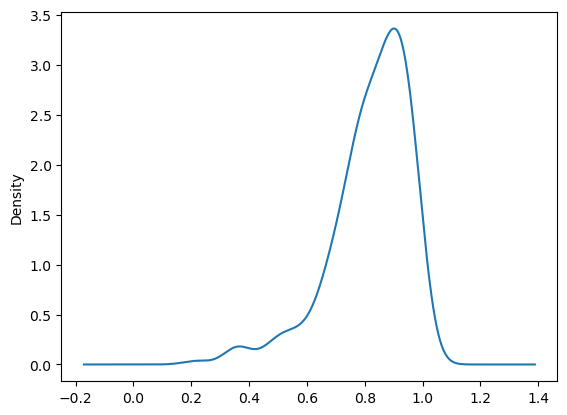

In [15]:
merged_hic_clustering.inter_rep_match_tbl.jaccard.plot.kde()

<Axes: xlabel='norm_lvl_rep1', ylabel='norm_lvl_rep2'>

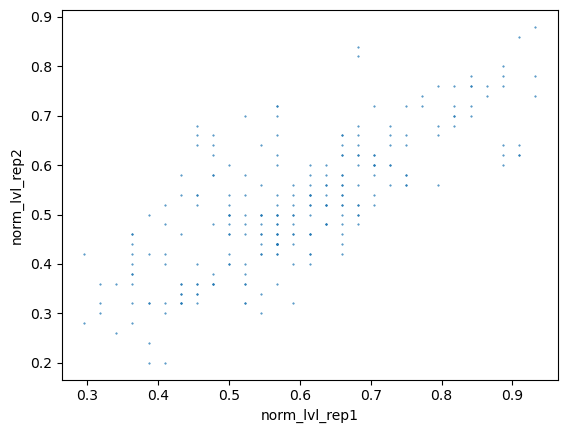

In [16]:
merged_hic_clustering.inter_rep_match_tbl.plot.scatter(x='norm_lvl_rep1',y='norm_lvl_rep2',s=0.2)

In [201]:
smooth_window = 150
rep1_obs_rcount_bdg = pd.concat([pd.DataFrame({'DNA_pos':rep1_df.start.to_numpy() }).assign(score = 1),
                             pd.DataFrame({'DNA_pos':rep1_df.start.to_numpy() + smooth_window}).assign(score = -1)
                            ]).sort_values('DNA_pos').assign(csum = lambda df_: df_.score.cumsum()).groupby('DNA_pos').agg(rcount = ('csum','max')).reset_index()
rep2_obs_rcount_bdg = pd.concat([pd.DataFrame({'DNA_pos':rep2_df.start.to_numpy() }).assign(score = 1),
                             pd.DataFrame({'DNA_pos':rep2_df.start.to_numpy() + smooth_window}).assign(score = -1)
                            ]).sort_values('DNA_pos').assign(csum = lambda df_: df_.score.cumsum()).groupby('DNA_pos').agg(rcount = ('csum','max')).reset_index()

bg_rcount_bdg = pd.concat([pd.DataFrame({'DNA_pos':bg_df.start.to_numpy() }).assign(score = 1),
                             pd.DataFrame({'DNA_pos':bg_df.start.to_numpy() + smooth_window}).assign(score = -1)
                            ]).sort_values('DNA_pos').assign(csum = lambda df_: df_.score.cumsum()).groupby('DNA_pos').agg(rcount = ('csum','max')).reset_index()


In [202]:
rep1_obs_rcount_bdg = rep1_obs_rcount_bdg.assign(rd = lambda df_: df_.rcount/rep1_df.shape[0])
rep2_obs_rcount_bdg = rep2_obs_rcount_bdg.assign(rd = lambda df_: df_.rcount/rep2_df.shape[0])
bg_rcount_bdg =bg_rcount_bdg.assign(rd = lambda df_: df_.rcount/bg_df.shape[0])

In [203]:
candidate_clusters_df = merged_hic_clustering.inter_rep_match_tbl.assign(lvl = lambda df_: (df_.norm_lvl_rep1 + df_.norm_lvl_rep2)/2)

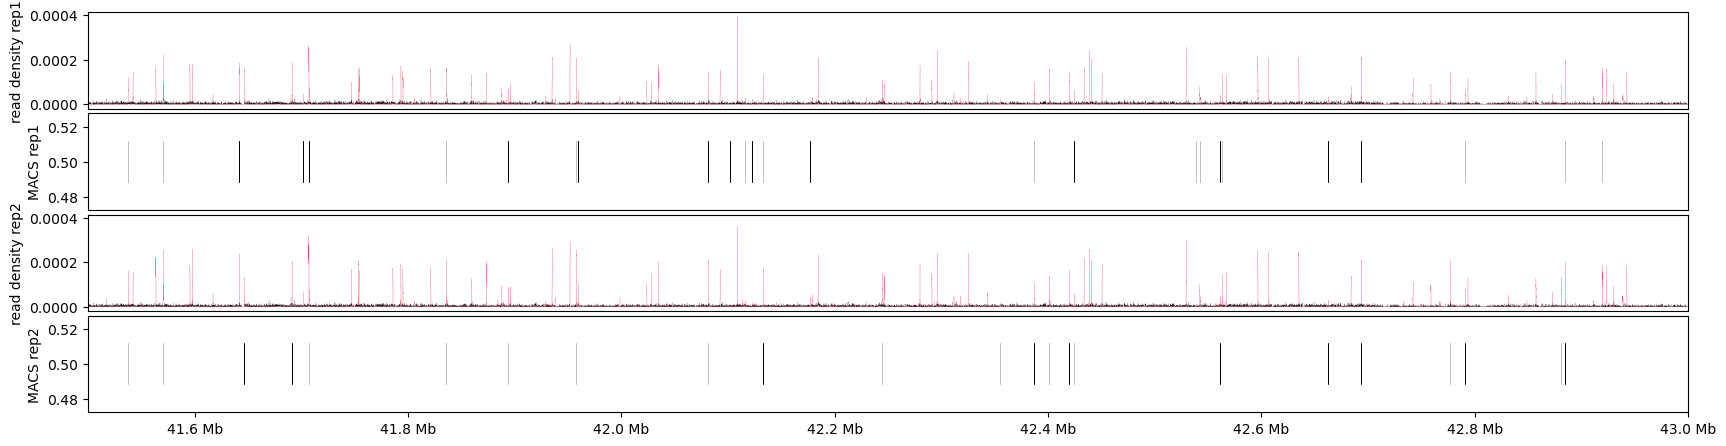

In [213]:
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(4, 1, height_ratios=(1, 1, 1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# plot_window_min = rep1_obs_rcount_bdg.DNA_pos.min()
# plot_window_max = rep1_obs_rcount_bdg.DNA_pos.max()

plot_window_min = 41_500_000				 
plot_window_max = 43_000_000

ax_dens_rep1 = fig.add_subplot(gs[0, 0],xlim = (plot_window_min,plot_window_max) )
ax_dens_rep1.xaxis.set_visible(False)
# ax_dens.set_yscale('log')
ax_dens_rep1.set_ylabel('read density rep1')

ax_agg_rep1 = fig.add_subplot(gs[1, 0],sharex=ax_dens_rep1)
ax_agg_rep1.xaxis.set_visible(False)
ax_agg_rep1.set_ylabel('MACS rep1')

ax_dens_rep2 = fig.add_subplot(gs[2, 0],sharex=ax_dens_rep1 )
ax_dens_rep2.xaxis.set_visible(False)
# ax_dens.set_yscale('log')
ax_dens_rep2.set_ylabel('read density rep2')

ax_agg_rep2 = fig.add_subplot(gs[3, 0],sharex=ax_dens_rep1)
ax_agg_rep2.xaxis.set_major_formatter(lambda x,pos: (str(np.round(x/1e6,decimals=2)) + " Mb"))
ax_agg_rep2.xaxis.set_visible(True)
ax_agg_rep2.set_ylabel('MACS rep2')


rep1_tmp_peak_df = bf.merge(rep1_peak_df.query('chrom == @tmp_chrom'))
for bin_idx in range(rep1_tmp_peak_df.shape[0]):
    tmp_cl =  rep1_tmp_peak_df.iloc[bin_idx,:]
    tmp_start = tmp_cl.start
    tmp_end = tmp_cl.end 
    # tmp_h = tmp_cl.n_intervals
    if bin_idx %2 == 0:
        ax_agg_rep1.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=30)
    else:
        ax_agg_rep1.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='silver',linewidth=30)

rep2_tmp_peak_df = bf.merge(rep2_peak_df.query('chrom == @tmp_chrom'))
for bin_idx in range(rep2_tmp_peak_df.shape[0]):
    tmp_cl =  rep2_tmp_peak_df.iloc[bin_idx,:]
    tmp_start = tmp_cl.start
    tmp_end = tmp_cl.end 
    # tmp_h = tmp_cl.n_intervals
    if bin_idx %2 == 0:
        ax_agg_rep2.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=30)
    else:
        ax_agg_rep2.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='silver',linewidth=30)

ax_dens_rep1.step(x=rep1_obs_rcount_bdg.DNA_pos.to_numpy(),y=rep1_obs_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='crimson')
ax_dens_rep1.step(x=bg_rcount_bdg.DNA_pos.to_numpy(),y=bg_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='black')

ax_dens_rep2.step(x=rep2_obs_rcount_bdg.DNA_pos.to_numpy(),y=rep2_obs_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='crimson')
ax_dens_rep2.step(x=bg_rcount_bdg.DNA_pos.to_numpy(),y=bg_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='black')


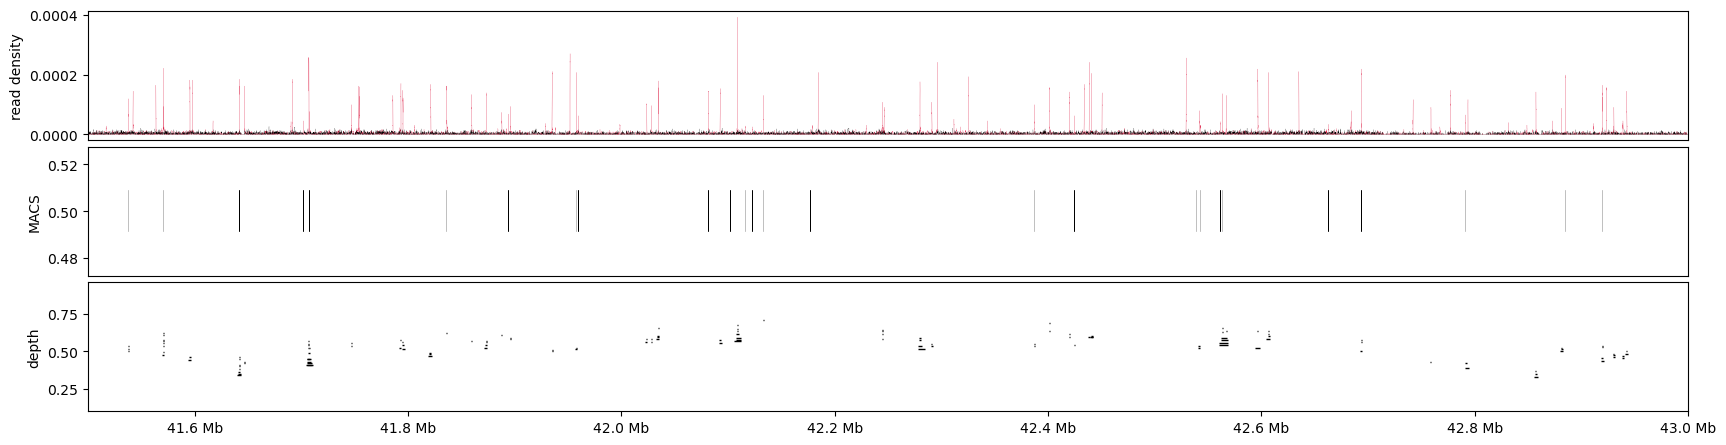

In [212]:
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(3, 1, height_ratios=(1, 1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# plot_window_min = rep1_obs_rcount_bdg.DNA_pos.min()
# plot_window_max = rep1_obs_rcount_bdg.DNA_pos.max()

plot_window_min = 41_500_000				 
plot_window_max = 43_000_000

ax_dens = fig.add_subplot(gs[0, 0],xlim = (plot_window_min,plot_window_max) )
ax_dens.xaxis.set_visible(False)
# ax_dens.set_yscale('log')
ax_dens.set_ylabel('read density')

ax_agg = fig.add_subplot(gs[1, 0],sharex=ax_dens)
ax_agg.xaxis.set_major_formatter(lambda x,pos: (str(np.round(x/1e6,decimals=2)) + " Mb"))
ax_agg.xaxis.set_visible(False)
ax_agg.set_ylabel('MACS')

ax_cl = fig.add_subplot(gs[2, 0],sharex=ax_dens)
ax_cl.xaxis.set_major_formatter(lambda x,pos: (str(np.round(x/1e6,decimals=2)) + " Mb"))
ax_cl.xaxis.set_visible(True)
ax_cl.set_ylabel('depth')

for bin_idx in range(candidate_clusters_df.shape[0]):
    tmp_cl =  candidate_clusters_df.iloc[bin_idx,:]
    tmp_start = tmp_cl.start
    tmp_end = tmp_cl.end 
    tmp_h = tmp_cl.lvl
    ax_cl.hlines(y=tmp_h,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=1)

tmp_peak_df = bf.merge(rep1_peak_df.query('chrom == @tmp_chrom'))
for bin_idx in range(tmp_peak_df.shape[0]):
    tmp_cl =  tmp_peak_df.iloc[bin_idx,:]
    tmp_start = tmp_cl.start
    tmp_end = tmp_cl.end 
    # tmp_h = tmp_cl.n_intervals
    if bin_idx %2 == 0:
        ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=30)
    else:
        ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='silver',linewidth=30)
ax_dens.step(x=rep1_obs_rcount_bdg.DNA_pos.to_numpy(),y=rep1_obs_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='crimson')
ax_dens.step(x=bg_rcount_bdg.DNA_pos.to_numpy(),y=bg_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='black')


In [26]:
(bf.cluster(candidate_clusters_df.loc[:,['chrom','start','end','pvalue_rep1','pvalue_rep2','zscore_rep1','zscore_rep2','lvl','w']])
.assign(cluster_w = lambda df_: df_.cluster_end -df_.start)
.sort_values('cluster_w')
)

,chrom,start,end,pvalue_rep1,pvalue_rep2,zscore_rep1,zscore_rep2,lvl,w,cluster,cluster_start,cluster_end,cluster_w
87,chr22,18954496,18954561,0.029519,0.029111,1.888009,1.894084,0.376929,65,17,18954496,18954561,65
893,chr22,50241235,50241310,0.009743,0.029111,2.336234,1.894084,0.643513,75,379,50241235,50241310,75
1076,chr22,33000814,33000902,0.006222,0.023232,2.499408,1.991209,0.753025,88,224,33000814,33000902,88
781,chr22,25235924,25236019,0.013868,0.009597,2.201108,2.341795,0.581352,95,133,25235924,25236019,95
858,chr22,42473648,42473756,0.033717,0.039930,1.828869,1.751551,0.458698,108,325,42473648,42473756,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,chr22,38764221,38769919,0.000176,0.000903,3.574626,3.120619,0.664789,5698,299,38759769,38782124,17903
466,chr22,38764221,38782124,0.015726,0.013890,2.151448,2.200496,0.644347,17903,299,38759769,38782124,17903
575,chr22,38764221,38767948,0.000639,0.001911,3.221082,2.892670,0.685232,3727,299,38759769,38782124,17903
425,chr22,38761623,38782124,0.015726,0.029271,2.151448,1.891747,0.634543,20501,299,38759769,38782124,20501


In [37]:
bf.count_overlaps(peak_df.query('chrom == "chr22"'),candidate_clusters_df).assign(in_agg = lambda df_: df_.loc[:,'count'].gt(0)).query("IDR >= 100").in_agg.mean()

np.float64(0.3618368962787015)

<Axes: xlabel='zscore_rep1', ylabel='zscore_rep2'>

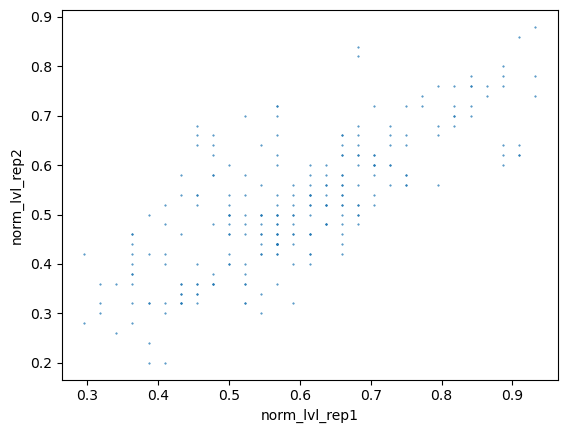

In [17]:
merged_hic_clustering.inter_rep_match_tbl.plot.scatter(x='zscore_rep1',y='zscore_rep2',s=0.2)

<Axes: xlabel='avg_lvl', ylabel='w'>

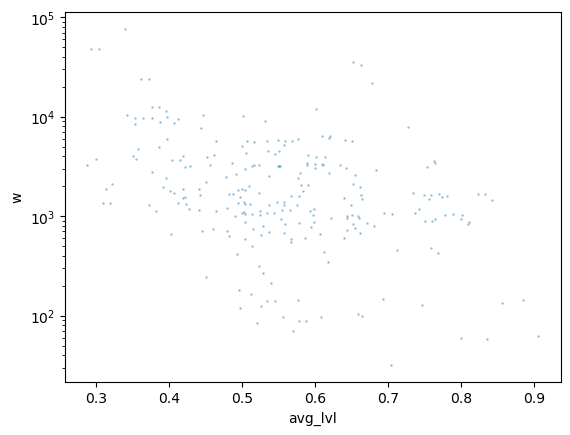

In [216]:
merged_hic_clustering.inter_rep_match_tbl.assign(avg_lvl = lambda df_: (df_.norm_lvl_rep1 + df_.norm_lvl_rep2)/2).plot.scatter(x='avg_lvl',y='w',logy=True,s=1,alpha=0.3)

In [19]:
def produce_cluster_size_quantile_curve_df(res_tbl,lvl_vec_length,window_width):
    expectile_tbl = res_tbl.assign(avg_lvl = lambda df_: (df_.norm_lvl_rep1 + df_.norm_lvl_rep2)/2)
    lvl_vec = np.linspace(expectile_tbl.avg_lvl.min(),expectile_tbl.avg_lvl.max(),lvl_vec_length)
    unique_lvl_vec = expectile_tbl.avg_lvl.drop_duplicates().sort_values().to_numpy()
    window_size = int(np.ceil(len(unique_lvl_vec) * (window_width)))
    nbrs = NearestNeighbors(n_neighbors=window_size, algorithm='ball_tree').fit(unique_lvl_vec.reshape(-1, 1))
    lvl_nn_array = nbrs.kneighbors(lvl_vec.reshape(-1, 1))[1]
    dfs = []
    for tmp_lvl_idx in range(lvl_nn_array.shape[0]):
        tmp_lvl_window = unique_lvl_vec[lvl_nn_array[tmp_lvl_idx,:],]
        dfs.append(expectile_tbl.query("avg_lvl in @tmp_lvl_window").w.quantile(np.linspace(0.1,0.9,5)).reset_index().rename(columns={'index':'quantile'}).assign(lvl = lvl_vec[tmp_lvl_idx]))
    
    return pd.concat(dfs)

In [189]:
np.linspace(0.1,0.9,5)

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [20]:
quantile_curves_df = produce_cluster_size_quantile_curve_df(merged_hic_clustering.inter_rep_match_tbl,100,0.1)
cmap = plt.get_cmap('cividis')
norm = plt.Normalize(quantile_curves_df.loc[:,'quantile'].min(), quantile_curves_df.loc[:,'quantile'].max())
line_colors = plt.cm.cividis(norm(quantile_curves_df.loc[:,'quantile'].drop_duplicates().to_numpy()))
line_color_dict = {quantile_curves_df.loc[:,'quantile'].drop_duplicates().sort_values().to_numpy()[i]:line_colors[int(i),:] for i in range(line_colors.shape[0])}


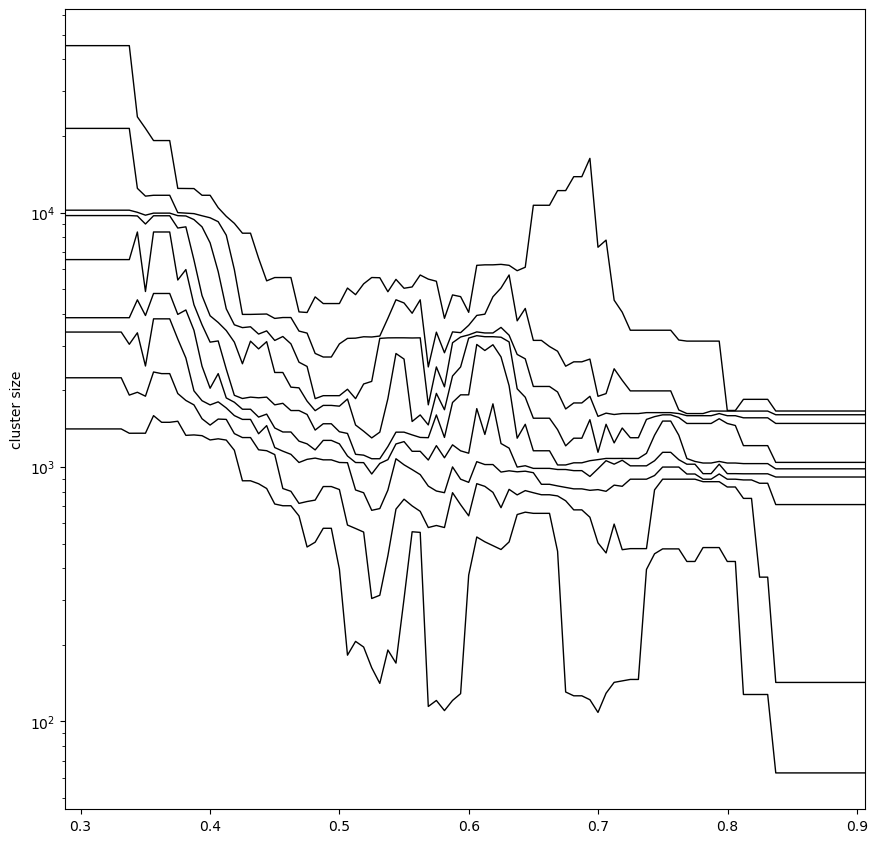

In [21]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1, 1,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
plot_window_min = quantile_curves_df.lvl.min()
plot_window_max = quantile_curves_df.lvl.max()

# plot_window_min = 35_000_000				 
# plot_window_max = 45_000_000

ax_curve = fig.add_subplot(gs[0, 0],xlim = (plot_window_min,plot_window_max) )
ax_curve.set_yscale('log')
ax_curve.set_ylabel('cluster size (bp)')
ax_curve.set_xlabel('cluster depth')

for quant_val in quantile_curves_df.loc[:,'quantile'].drop_duplicates().to_list():
    tmp_curve =  quantile_curves_df.query("quantile == @quant_val").sort_values('lvl')
    ax_curve.plot(tmp_curve.lvl.to_numpy(),tmp_curve.w.to_numpy(),color= line_color_dict[quant_val],label = np.round(quant_val,2),linewidth=1)

ax_curve.legend()

In [171]:
(
    bf.merge(
        bf.overlap(bf.merge(merged_hic_clustering.inter_rep_match_tbl.loc[:,['chrom','start','end','w']]).assign(w = lambda df_: df_.end-df_.start),rep1_peak_df,how='inner',return_overlap=True)
        .loc[:,['chrom','overlap_start','overlap_end']]
        .rename(columns = {'overlap_start':'start','overlap_end':'end'})
            )
    .assign(w = lambda df_: df_.end -df_.start)
    .w.sum()/bf.merge(rep1_peak_df).assign(w = lambda df_: df_.end -df_.start).w.sum()
)

np.float64(0.003962477855791557)

In [176]:
bf.merge(merged_hic_clustering.inter_rep_match_tbl.loc[:,['chrom','start','end','w']]).assign(w = lambda df_: df_.end-df_.start).w.mean()

np.float64(4326.737704918033)

In [175]:
bf.merge(rep1_peak_df).assign(w = lambda df_: df_.end -df_.start).w.mean()

np.float64(228.35037114050147)